In [1]:
from utils import *
from preprocessing import *
from cnn_model import *
SIZE = 256

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
'''
# loading data and pre-process

'''
# original image, binary mask, contour(self-defined class)
img_train, mask_train, contour_train = prepareDataset(TRAIN_CONTOUR_PATH, TRAIN_IMG_PATH)
img_test, mask_test, contour_test = prepareDataset(TEST_CONTOUR_PATH, TEST_IMG_PATH)
img_val, mask_val, contour_val = prepareDataset(VAL_CONTOUR_PATH, VAL_IMG_PATH)

#Region of interest, aka bounding box computed from the contour
ROI_train = get_ROI(contour_train)
ROI_test = get_ROI(contour_test)
ROI_val = get_ROI(contour_val)

#Re-organize the data for CNN
img_tv = np.concatenate((img_train, img_val), axis = 0)
roi_tv = np.concatenate((ROI_train, ROI_val), axis = 0)
print(img_tv.shape)
print(roi_tv.shape)

X, Y = reformDataXY(img_tv, roi_tv)
X_test, Y_test = reformDataXY(img_test, ROI_test)

#Get the result from the first step (CNN):

cnn_data = {'X_train': X, 'X_test': X_test, 'Y_train': Y, 'Y_test': Y_test}
y_pred = run_cnn(cnn_data)
cropped = get_cropped(img_test, y_pred, win_size = 100)

print(y_pred.shape)

Number of examples: 260

Processing 260 images and labels ...

Number of examples: 279

Processing 279 images and labels ...

Number of examples: 266

Processing 266 images and labels ...

(526, 256, 256, 1)
(526, 32, 32)
(279, 1, 32, 32)


In [3]:
'''
#probably useless
def get_mask_roi_pred(img, y_pred, roi_size = 32):
    n = img.shape[0]
    mask_roi = np.zeros((n, 256, 256, 1))
    for i in range(y_pred.shape[0]):
        pred = y_pred[i, 0, :,:]
        [x_min, x_max, y_min, y_max] = get_bbox_single(pred)
        mask_roi[i] = cv2.rectangle(mask_roi[i], (x_max,y_max),(x_min,y_min),1,-1)*255   
    return mask_roi

mask_roi =get_mask_roi_pred(img_test,y_pred)
print(mask_roi.shape)
'''

'\n#probably useless\ndef get_mask_roi_pred(img, y_pred, roi_size = 32):\n    n = img.shape[0]\n    mask_roi = np.zeros((n, 256, 256, 1))\n    for i in range(y_pred.shape[0]):\n        pred = y_pred[i, 0, :,:]\n        [x_min, x_max, y_min, y_max] = get_bbox_single(pred)\n        mask_roi[i] = cv2.rectangle(mask_roi[i], (x_max,y_max),(x_min,y_min),1,-1)*255   \n    return mask_roi\n\nmask_roi =get_mask_roi_pred(img_test,y_pred)\nprint(mask_roi.shape)\n'

In [4]:
#get predicted contour mask
def get_mask_pred(img,y_pred):
    n = img.shape[0]
    mask_contour = np.zeros((n, 80, 80, 1))
    for i in range(y_pred.shape[0]):
        pred = y_pred[i, 0, :,:]
        [x_min, x_max, y_min, y_max] = get_bbox_single(pred)
        mask_contour[i] =  img[i][x_min:x_max, y_min:y_max]   
    return mask_contour

mask_contour =get_mask_pred(mask_test,y_pred)
print(mask_contour.shape)

(279, 80, 80, 1)


In [5]:
def open_data_AE(y_pred):
    """
    Open dataset from the output of the CNN and
    unroll it as 64*64 = vector of 4096 elements
    :param y_pred: CNN output
    :return: input AE, output
    """
    input_AE = []
    contour_experts = []
    for j in range(y_pred.shape[0]):
        in_AE = cv2.resize(cropped[j],(64 , 64))
        contour = cv2.resize(mask_contour[j], (64,64), interpolation = cv2.INTERSECT_NONE)
        input_AE.append(in_AE)
        contour_experts.append(contour)
    return np.array(input_AE).reshape((-1, 64*64)), np.array(contour_experts).reshape((-1, 64*64))

In [6]:
X_train, Y_train = open_data_AE(y_pred)
X_train.shape, Y_train.shape

((279, 4096), (279, 4096))

In [7]:
from StackedAeModel import SAE

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [8]:
#apply stacked auto encoder to preprocessed data
h, model = SAE(X_train,Y_train)

In [9]:
def model_1(get_history=False, verbose=0, param_reg=3*0.001):
    """
    First part of the stacked AE.
    Train the AE on the ROI input images.
    :param X_train: ROI input image
    :param get_history: boolean to return the loss history
    :return: encoded ROI image
    """
    autoencoder_0 = Sequential()
    encoder_0 = Dense(input_dim=4096, units=100, kernel_regularizer=regularizers.l2(param_reg))
    decoder_0 = Dense(input_dim=100, units=4096, kernel_regularizer=regularizers.l2(param_reg))
    autoencoder_0.add(encoder_0)
    autoencoder_0.add(decoder_0)
    autoencoder_0.compile(loss= customized_loss,optimizer='adam', metrics=['accuracy'])

    temp_0 = Sequential()
    temp_0.add(encoder_0)
    temp_0.compile(loss= customized_loss, optimizer='adam', metrics=['accuracy'])
    return decoder_0
def customized_loss(y_true, y_pred, alpha=0.0001, beta=3):
    """
    Create a customized loss for the stacked AE.
    Linear combination of MSE and KL divergence.
    """
    #customize your own loss components
    loss1 = losses.mean_absolute_error(y_true, y_pred)
    loss2 = losses.kullback_leibler_divergence(y_true, y_pred)
    #adjust the weight between loss components
    return (alpha/2) * loss1 + beta * loss2

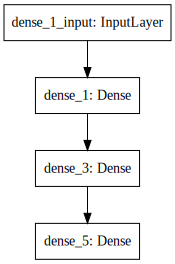

In [13]:
import pydot
import graphviz
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [9]:
from keras.utils import plot_model
#plot_model(model, to_file='SAE.png')

plot_model(model, to_file='SAE.png', show_shapes=True, show_layer_names=True)

Text(0.5,0,'epochs')

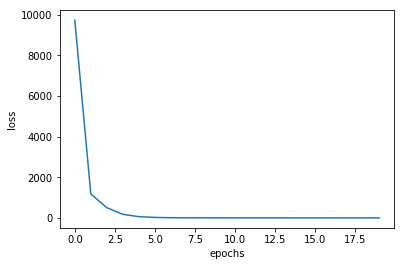

In [9]:
plt.plot(range(len(h)), h)
plt.ylabel('loss')
plt.xlabel('epochs')

In [10]:
from StackedAeModel import SAE
#apply stacked auto encoder to preprocessed data
h1, model1 = SAE(X_train,Y_train)
h2, model2 = SAE(X_train,Y_train,'random_uniform')
h3, model3 = SAE(X_train,Y_train,'random_normal')

In [13]:
import pydot
import graphviz
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

plot_model(model1, to_file='model1.png', show_shapes=True, show_layer_names=True)


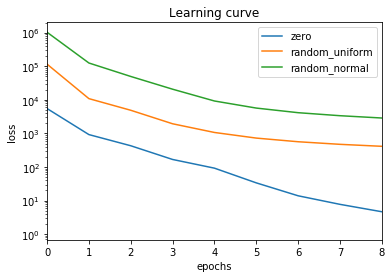

In [11]:
plt.plot(range(len(h1)), h1,label='zero')
plt.plot(range(len(h2)), h2,label='random_uniform')
plt.plot(range(len(h3)), h3,label='random_normal')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title("Learning curve")
plt.legend()
plt.xlim([0,8])
plt.yscale("log", nonposy='clip')

In [12]:
def prediction_plot(X, model, idx):
    """
    Compute the Inferred shape binary mask using the trained stacked AE model
    :param X: dataset to predict
    :param model: trained AE model
    :param idx: index of the particular picture to return
    :return: inferred shape binary mask, infered shape on the MR image
    """
    contours = model.predict(X)
    contour = contours[idx].reshape((64,64))
    # thresholding
    binary = cv2.threshold(contour, 0, 1, cv2.INTERSECT_NONE)
    return binary[1], binary[1]*X[idx].reshape(64,64)

In [13]:
#n is number of test images
n = img_test.shape[0]
pred_mask,pred_img=[],[]
for i in range(n):
    bin_mask,img = prediction_plot(X_train,model,i)
    pred_mask.append(bin_mask)
    pred_img.append(img)
pred_mask = np.array(pred_mask)
pred_img = np.array(pred_img)
print (pred_mask.shape)

(279, 64, 64)


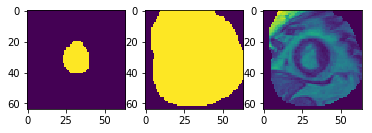

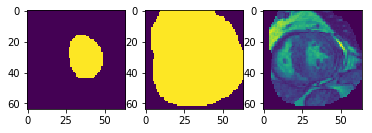

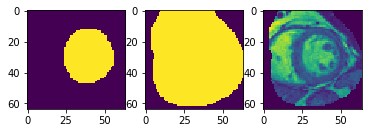

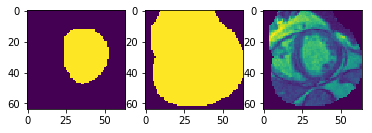

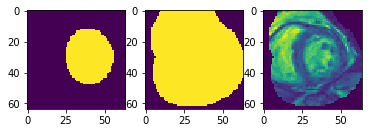

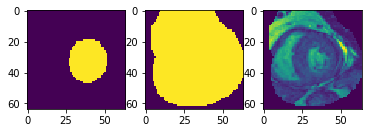

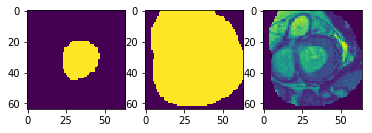

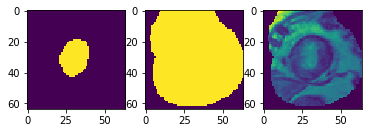

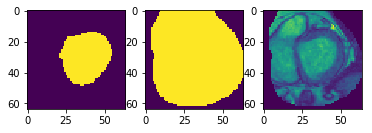

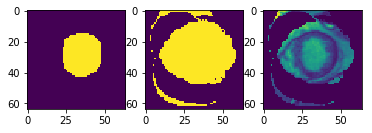

In [14]:
for i in range(10):
    plt.figure()
    plt.subplot(131)
    plt.imshow(Y_train[i].reshape((64,64)))
    plt.subplot(132)
    plt.imshow(pred_mask[i])
    plt.subplot(133)
    plt.imshow(pred_img[i])

In [16]:
#Metrics
def dice_metric(X, Y):
    return np.sum(X[Y==1])*2.0 / (np.sum(X) + np.sum(Y))

def conformity_coefficient(X, Y):
    return (3*dice_metric(X,Y)-2)/dice_metric(X,Y)

In [17]:
dm = np.zeros(n)
cc= np.zeros(n)
for i in range(n):
    Y_true = Y_train[i].reshape((64,64))
    dm[i] = dice_coef(Y_true, pred_mask[i])
    cc[i] = conformity_coefficient(pred_mask[i],Y_true)
#print(dm)

/home/jingxi/.local/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


In [18]:
print dm.mean()

0.38301963423603397
